<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/JonasNylund/Lab-4/jonasnylund_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Function Approximations**
**Jonas Nylund**

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [2]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Jonas Nylund (jonasnyl@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

The solution has been discussed and partly implemented in colaboration with Helmer Nylén, especially the ugliest hacks for sparse matrices.

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
import scipy.integrate as integrate
import scipy.sparse as sparse;

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

The L2 projection of a function on a space of linear functions
$
\displaystyle
P_h f(x) = \sum_{j=0}^{m+1} \alpha_j\phi_j(x)
$

as per equation 9.13 in the lecture notes.
This gives the matrix equation 
$
A\alpha = b
$, 
where $alpha$ is the solution vector, and A i a diagonal matrix with $a_{i,i} = \frac{h_i}{3} + \frac{h_{i+1}}{3}$, $a_{i,i+1} = \frac{h_{i+1}}{6}$, and $a_{i,i-1} = \frac{h_i}{6}$, where $h_i$ is the length of the i:th mesh element.

$b_i$ is evaluated as the integral $\int_I f(x)\phi_i(x)dx$.
Since $\phi_i$ is non-zero only on a part of the intervall, we have that 
$b_i = \int_{x_{i-1}}^{x_i} f(x)\cdot \frac{x-x_{i-1}}{x_i-x_{i-1}}dx + \int_{x_i}^{x_{i+1}} f(x)\cdot \frac{x_{i+1}-x}{x_{i+1}-x_i}$, where $x_i$ is the node point of the i:th mesh node.

# **Methods**

The above equations gives us the following algorithm for calculating the system of linear equations.

In [0]:
def phi1(f, x0,x1):
  f1 = lambda x: f(x)*(x-x0)/(x1-x0);
  return integrate.quad(f1, x0, x1)[0];

def phi0(f, x1,x2):
  f2 = lambda x: f(x)*(x2-x)/(x2-x1);
  return integrate.quad(f2, x1, x2)[0];

def assemble1DSystem(f, mesh):

  k = len(mesh);
  
  #create a sparse matrix with right dimensions and elements
  A = sparse.csr_matrix(sparse.diags(([1]*(k-1), [1]*k, [1]*(k-1)),(-1,0,1)))
  b = np.zeros(k);

  for i in range(1,k-1):

    hi = mesh[i]-mesh[i-1];
    hi1 = mesh[i+1]-mesh[i];

    A[i,i] = hi/3 + hi1/3;
    A[i,i-1] = hi/6;
    A[i,i+1] = hi1/6;

    b[i] += phi1(f, mesh[i-1], mesh[i]);
    b[i] += phi0(f, mesh[i], mesh[i+1]);

  ## Endpoints are taken car of manually, since we are missing some elements
  #beginning
  A[0,0] = (mesh[1]-mesh[0])/3;
  A[0,1] = (mesh[1]-mesh[0])/6;    
  b[0] = phi0(f, mesh[0], mesh[1]);
  #end
  A[-1,-1] = (mesh[-1]-mesh[-2])/3;
  A[-1,-2] = (mesh[-1]-mesh[-2])/6;
  b[-1] = phi1(f, mesh[-2], mesh[-1]);

  return A,b;
    
    


An example of the approximated function and the exact solution

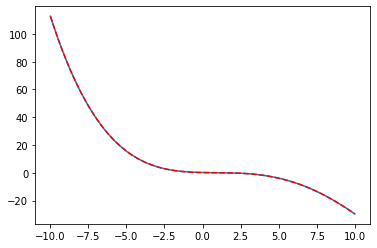

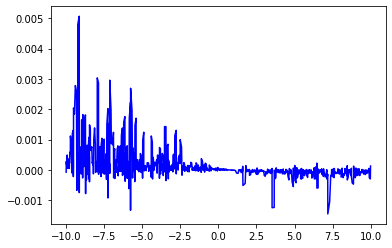

In [14]:
n = 1000;

intervall = [-10,10];
mesh = np.sort(np.random.rand(n) * (intervall[1]-intervall[0]) +intervall[0]);

f = np.polynomial.polynomial.Polynomial([(np.random.rand()*2-1)/(i**2+1) for i in range(np.random.randint(5,20))], [-1,1], [-1,1]);

y = f(mesh);

A,b = assemble1DSystem(f, mesh);
alpha = sparse.linalg.spsolve(A,b);

plt.plot(mesh,y)
plt.plot(mesh,alpha, "r--");

plt.figure();
plt.plot(mesh, f(mesh)-alpha, 'b-');



# **Results**

Calculating the residues for the approximation against the exact solution gives the folowing relationship between mesh coarsness and overall error.

In a log-log plot the residue follows a linear path, meaning that the number of gridpoints is inversely proportional to the error.

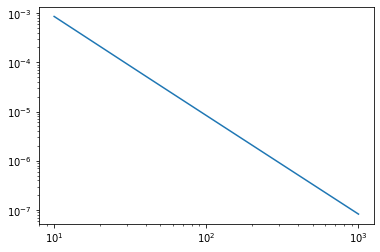

In [6]:
def interpolate(x1, x2, y1, y2, x):
  return (y2-y1)/(x2-x1)*(x-x1)+y1;

def diff(f, alpha, mesh, x):
  i = 0;
  while(mesh[i] < x):
    i+= 1;
  return np.abs(f(x) - interpolate(mesh[i-1], mesh[i], alpha[i-1], alpha[i], x));

def residu(f, intervall, n, mesh):
  A,b = assemble1DSystem(f, mesh);
  alpha = sparse.linalg.spsolve(A,b);

  m = n*10;
  mesh2 = np.arange(m)/m * (intervall[1]-intervall[0]) +intervall[0];

  s = 0;
  for i in range(len(mesh2)):
    s += diff(f, alpha, mesh, mesh2[i]);
  return s/m;


f = np.polynomial.polynomial.Polynomial([(np.random.rand()*2-1)/(i**2+1) for i in range(np.random.randint(5,20))], [-1,1], [-1,1]);
intervall = [-1,1];

n = [];
r = [];
for i in range(10,1010,10):
 
  mesh = np.arange(i+1)/i * (intervall[1]-intervall[0]) +intervall[0]

  n.append(i);
  r.append(residu(f, intervall, i, mesh));

plt.loglog(n,r);


# **Discussion**

The point of this kind of linear approximation of a function that we know know exactly is unclear. I don't understand why this is something we want to do. Storing the matrix A and vector b is memory inefficient compared to just using the function itself. 

The convergence rate of the approximaiton is as expected linear in a log-log plot, since the linear approximation gets closer the to the function the more points we evaluate it in. However, more mesh points leads to a larger system of linear equations to solve, which takes a long time.

To conclude, the approximation works, and seems to converge to the exact solution as expected. The accuracy increases as the mesh gets finer, which is also as expected.